In [1]:
# Импорты

import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


c:\repos\Kolesa-python-exam\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [ ]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [ ]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

In [34]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


In [35]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [36]:
data.dtypes

event_date    object
y              int64
dtype: object

In [37]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [38]:
data.columns = ['ds', 'y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


<Axes: xlabel='ds'>

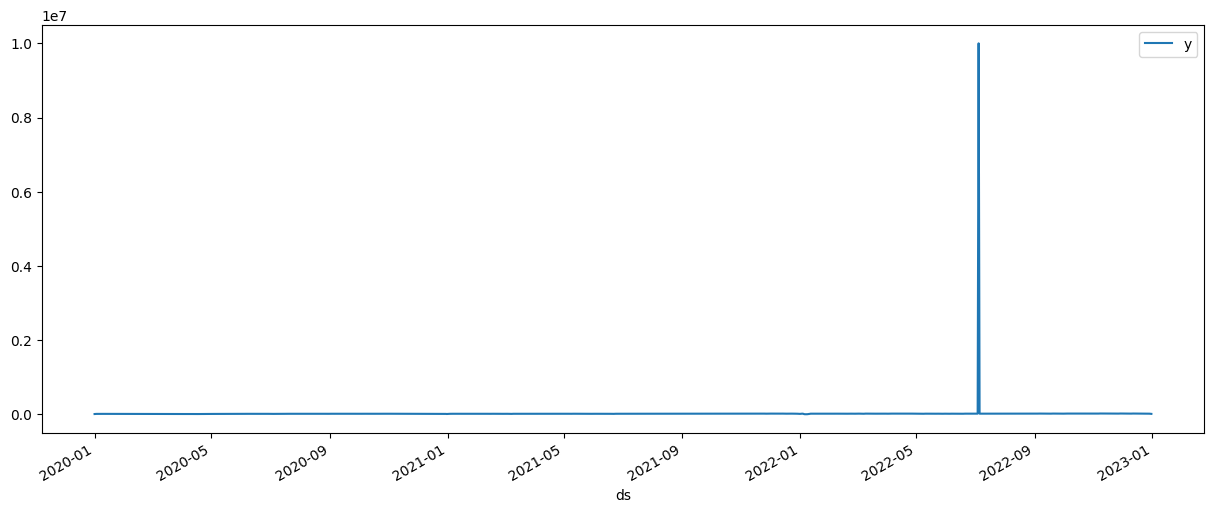

In [39]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [40]:
data.idxmax()

ds   2022-12-31
y    2022-07-05
dtype: datetime64[ns]

In [41]:
for i in range(2):
    data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_17400\1448882573.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


<Axes: xlabel='ds'>

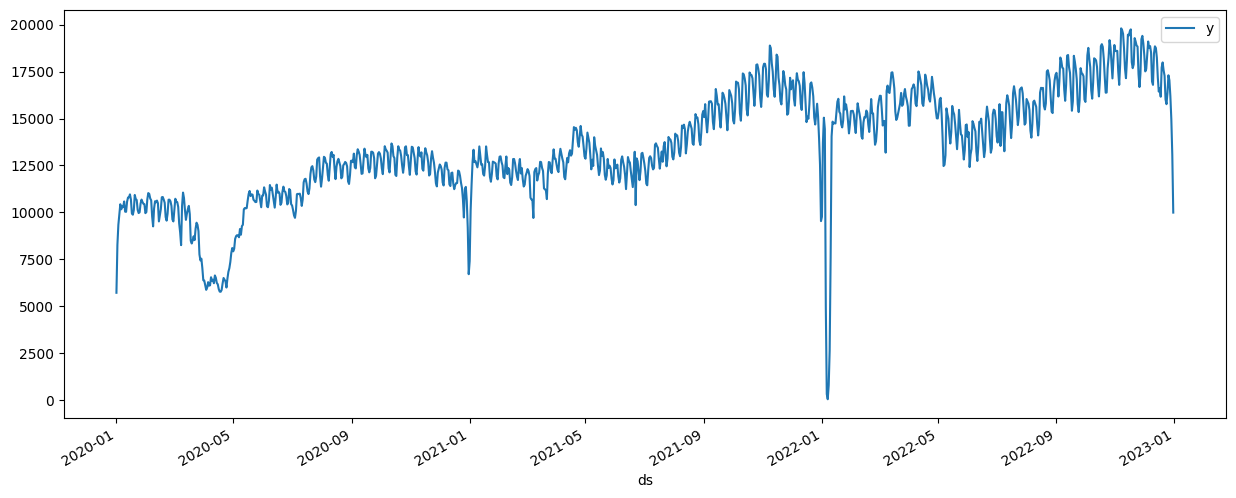

In [42]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [43]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

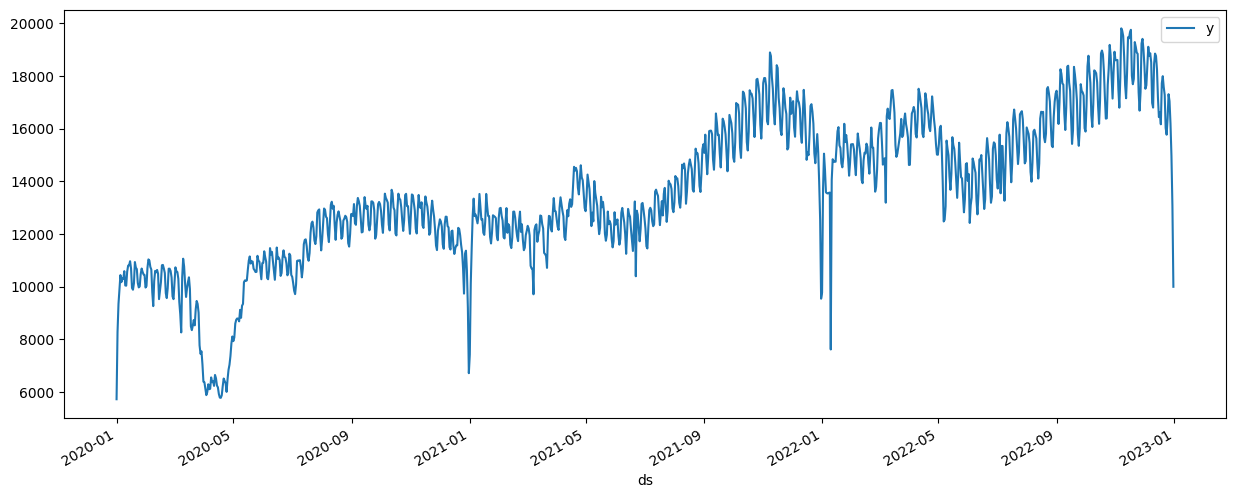

In [44]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [45]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03'))
            | (date >=pd.to_datetime('2023-03-23')) & (date <= pd.to_datetime('2023-04-23')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)
data.head()
    

,ds,y,is_ramadan,ramadan
ds,,,,
2020-01-01,2020-01-01,5721.0,False,0
2020-01-02,2020-01-02,8274.0,False,0
2020-01-03,2020-01-03,9344.0,False,0
2020-01-04,2020-01-04,9864.0,False,0
2020-01-05,2020-01-05,10435.0,False,0


In [46]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0: 'holiday'})
df_holidays['ds'] = df_holidays.index
# df_holidays.index = df_holidays['ds']
df_holidays.head()

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22


In [47]:
from prophet.plot import add_changepoints_to_plot
def get_mape(model, actual=data):
    return mean_absolute_percentage_error(actual['y'], model.predict(actual)['yhat'])

def plot(model, actual=data, threshold_changepoints=0.01):
    df_pred = model.predict(actual)
    df_pred.index = df_pred.ds
    df_plot = pd.concat([actual, df_pred], axis=1)
    ax = df_plot[:].plot(y=["y", "yhat"], kind = "line", figsize=(10, 10))
    a = add_changepoints_to_plot(ax, model, df_pred, threshold = threshold_changepoints)

In [48]:
initial = str(int(data.shape[0]/2)) + ' days'
horizon = str(int(data.shape[0]/20)) + ' days'
period = str(int(data.shape[0]/20)) + ' days'
print('initial:', initial) 
print('horizon:', horizon)
print('period:', period)

initial: 548 days
horizon: 54 days
period: 54 days


18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.09119391912990349)

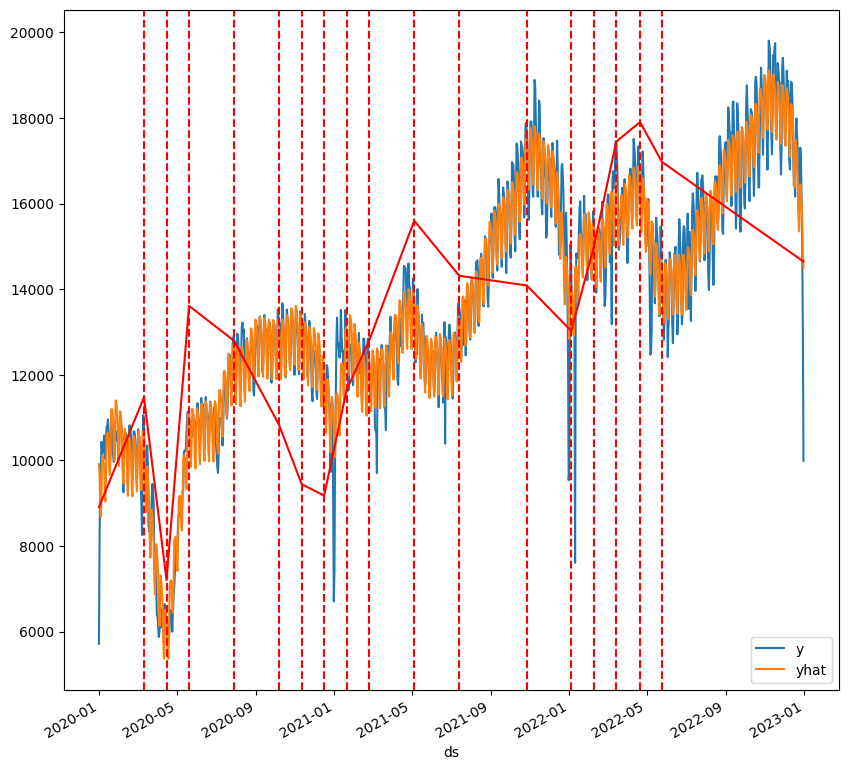

In [56]:
model = Prophet(changepoint_prior_scale=0.6)

model.fit(data)

cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

18:11:31 - cmdstanpy - INFO - Chain [1] start processing
18:11:31 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.08130191188065534)

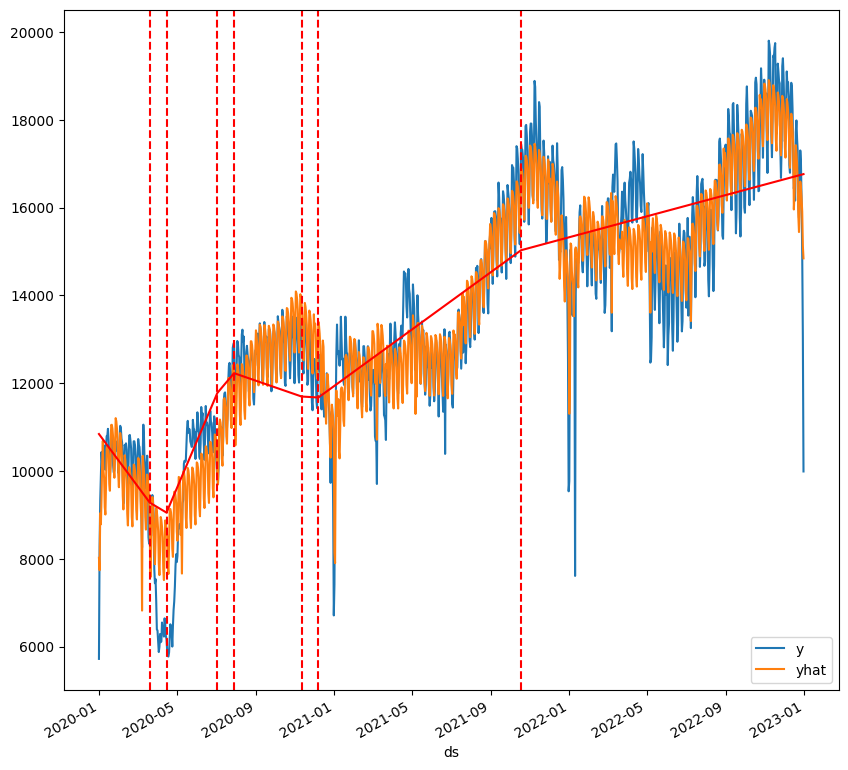

In [57]:
model = Prophet(holidays=df_holidays, changepoint_range=0.6)

model.fit(data)
cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

In [58]:
param_grid = {
    'changepoint_prior_scale': np.logspace(0, 10, 5, base = 500**(1/10))/1000,
    'seasonality_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'holidays_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'seasonality_mode': ['additive', 'multiplicative'],
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

In [59]:
def train(params): 
    model = Prophet(changepoint_range=0.8,
                    holidays = df_holidays,
                    **params).add_regressor('ramadan')
    
    model.fit(data)
    cv_results = cross_validation(
        model, 
        initial=initial, 
        horizon=horizon, 
        period=period,
        parallel="processes"
    )

    return np.average(performance_metrics(cv_results).mape.values)


In [60]:
mapes = []

print(len(all_params))

start_time = time()
for params in all_params:
    mapes.append(train(params))

print('Time elapsed:', time() - start_time)
best_params = all_params[np.argmin(mapes)]
'MAPE:', min(mapes) 

250


18:11:51 - cmdstanpy - INFO - Chain [1] start processing
18:11:51 - cmdstanpy - INFO - Chain [1] done processing
18:11:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:51 - cmdstanpy - INFO - Chain [1] start processing
18:11:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:01 - cmdstanpy - INFO - Chain [1] done processing
18:12:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Time elapsed: 1415.8011028766632


('MAPE:', 0.06744739339045805)

In [61]:
print(best_params)

{'changepoint_prior_scale': 0.10573712634405641, 'seasonality_prior_scale': 0.316227766016838, 'holidays_prior_scale': 3.162277660168381, 'seasonality_mode': 'additive'}


18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.06706628148529163)

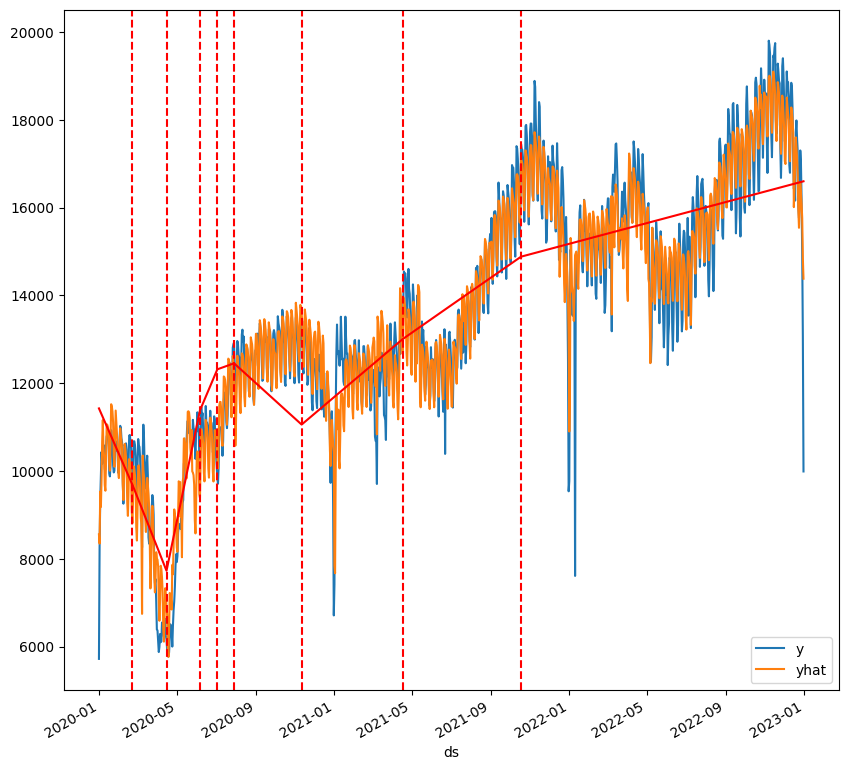

In [62]:
model = Prophet(holidays=df_holidays, changepoint_range=0.6, 
                **best_params).add_regressor('ramadan')
model.add_seasonality(name='monthly_season', period=30.5, fourier_order=7)

model.fit(data)
cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

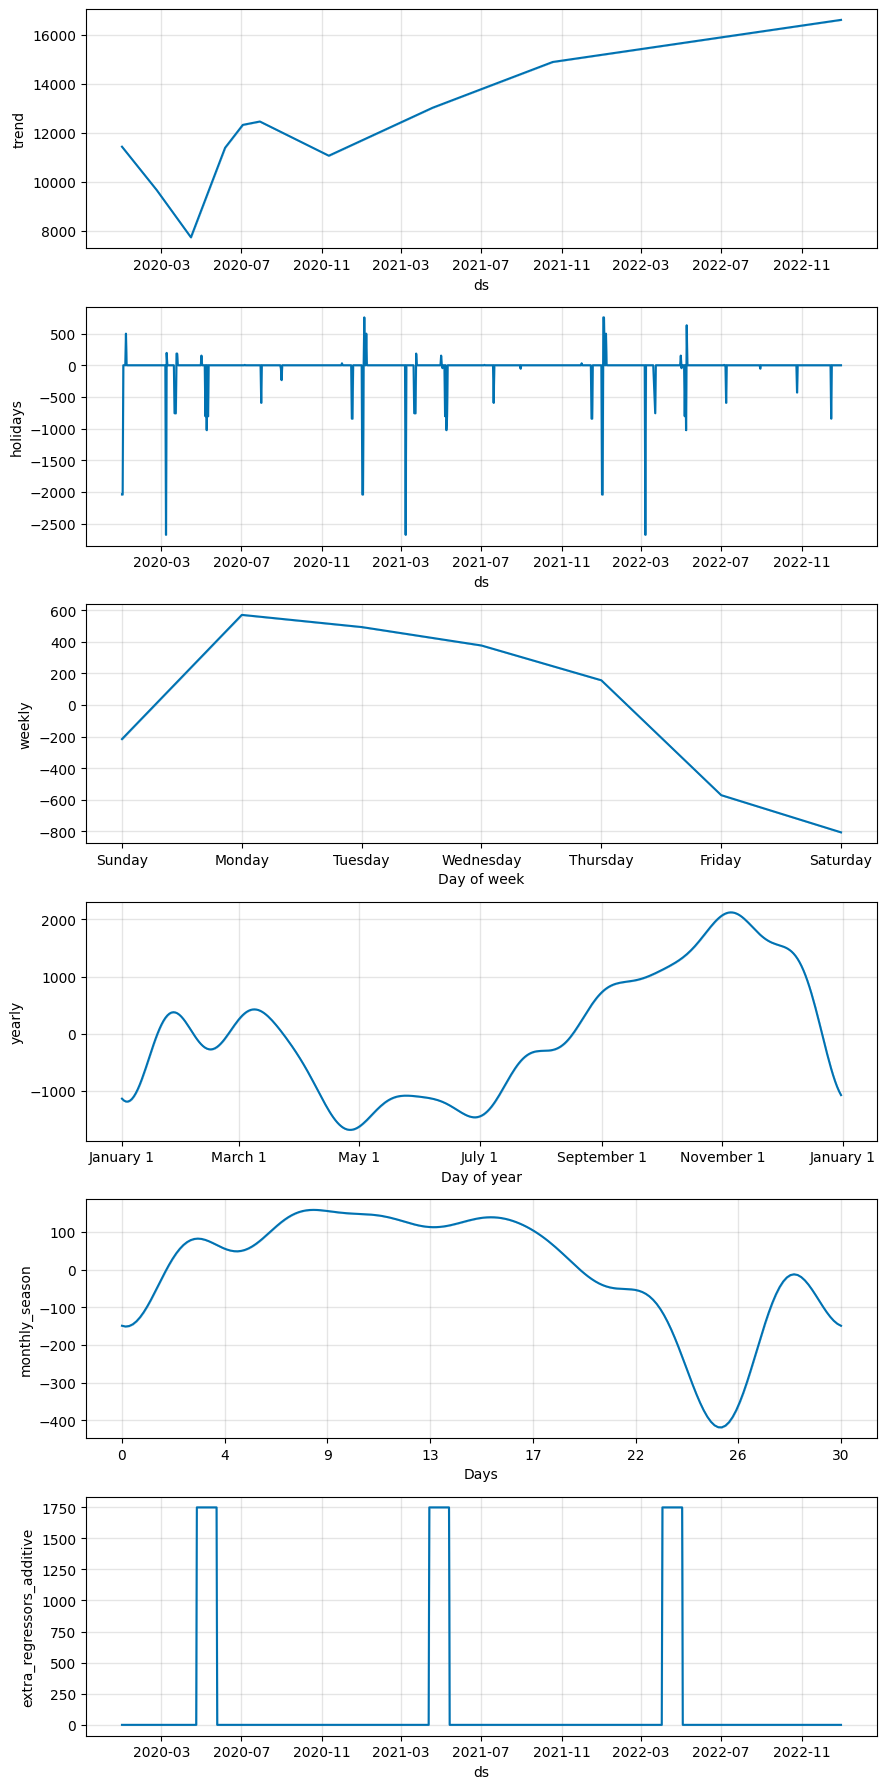

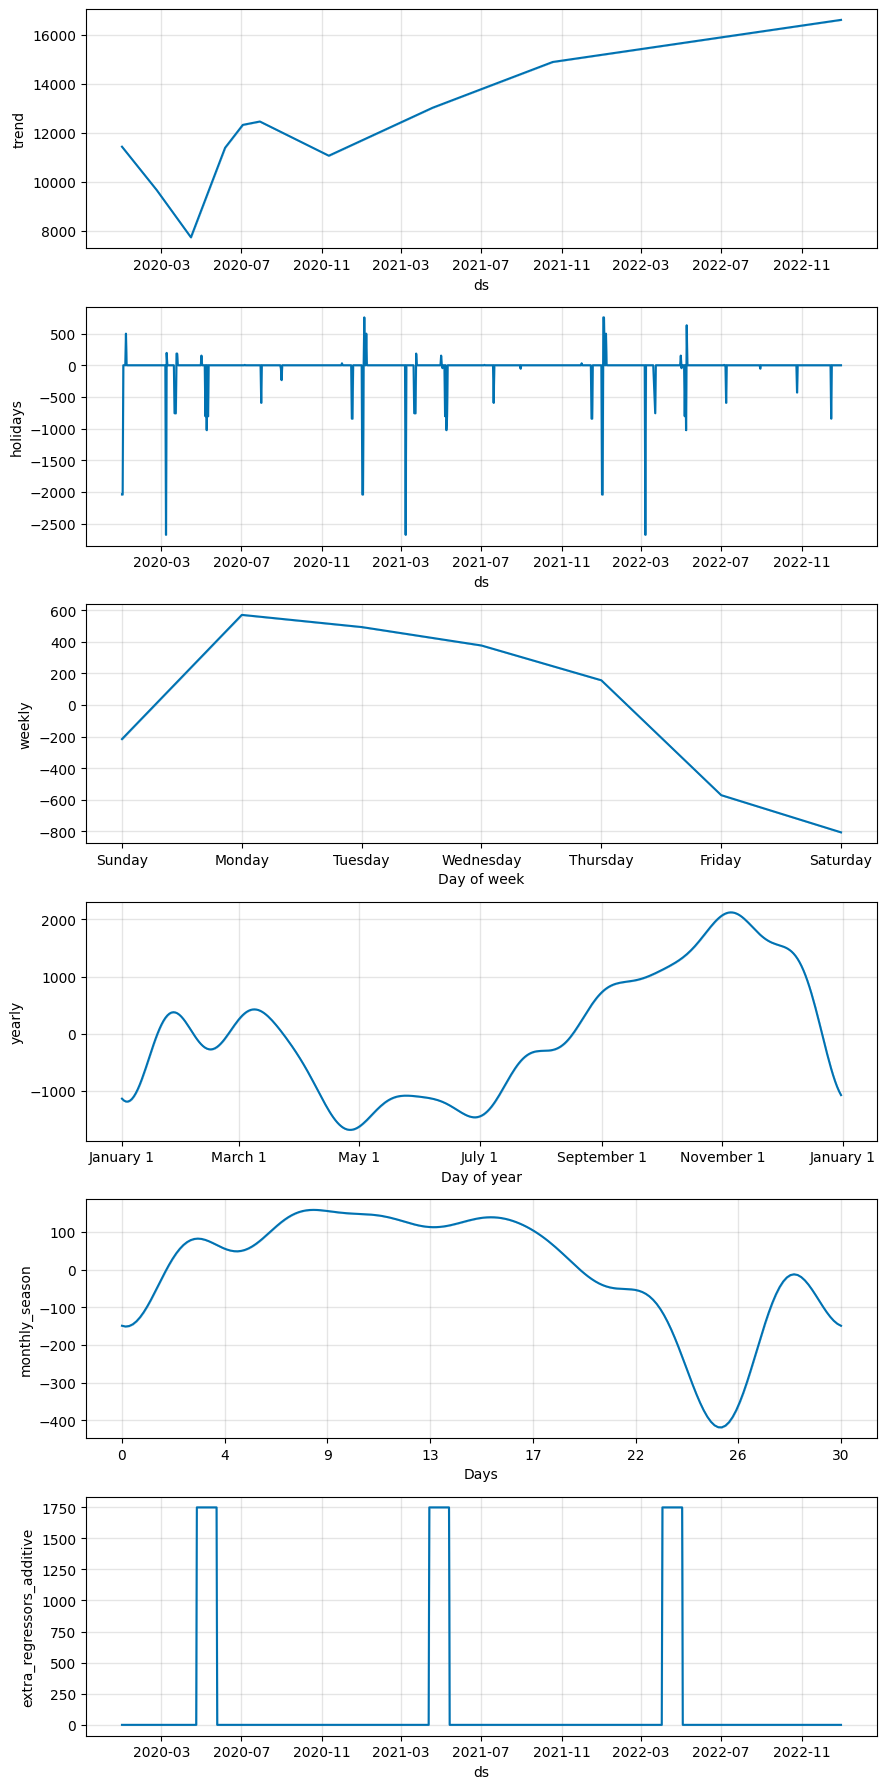

In [63]:
model.plot_components(model.predict(data))

In [64]:
train = data[:-int(data.shape[0]/20)]
test = data[-int(data.shape[0]/20):]
test = test.drop('ds',axis=1)
test = test.reset_index()

In [65]:
model = Prophet(holidays=df_holidays, changepoint_range=0.8, 
                **best_params).add_regressor('ramadan')
model.add_seasonality(name='monthly_season', period=30.5, fourier_order=7)

In [66]:
model.fit(train)

18:42:39 - cmdstanpy - INFO - Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
predict_data = model.make_future_dataframe(test.shape[0], include_history=False)

In [68]:
predict_data = predict_data.merge(test, on='ds', how='left')

In [69]:
predict_data = model.predict(predict_data)

In [70]:
predict_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Capital Day,Capital Day_lower,Capital Day_upper,Constitution Day of the Republic of Kazakhstan,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-08,16199.900790,17777.129418,19550.370570,16199.900790,16199.900790,0.0,0.0,0.0,0.0,...,464.546892,464.546892,464.546892,1993.672113,1993.672113,1993.672113,0.0,0.0,0.0,18669.453878
1,2022-11-09,16202.647785,17738.758705,19466.215577,16202.647785,16202.647785,0.0,0.0,0.0,0.0,...,353.484261,353.484261,353.484261,1965.698099,1965.698099,1965.698099,0.0,0.0,0.0,18610.971646
2,2022-11-10,16205.394779,17500.925945,19226.975161,16205.394779,16205.394779,0.0,0.0,0.0,0.0,...,152.088160,152.088160,152.088160,1933.090736,1933.090736,1933.090736,0.0,0.0,0.0,18355.907231
3,2022-11-11,16208.141773,16727.946618,18395.837777,16208.141773,16208.141773,0.0,0.0,0.0,0.0,...,-550.842682,-550.842682,-550.842682,1896.341849,1896.341849,1896.341849,0.0,0.0,0.0,17590.690442
4,2022-11-12,16210.888768,16532.627699,18243.138718,16210.888768,16210.888768,0.0,0.0,0.0,0.0,...,-764.511034,-764.511034,-764.511034,1856.026065,1856.026065,1856.026065,0.0,0.0,0.0,17381.939366
5,2022-11-13,16213.635762,17016.897043,18752.666606,16213.635762,16213.635762,0.0,0.0,0.0,0.0,...,-209.227057,-209.227057,-209.227057,1812.788007,1812.788007,1812.788007,0.0,0.0,0.0,17960.365016
6,2022-11-14,16216.382757,17904.134212,19596.941186,16216.382757,16216.382757,0.0,0.0,0.0,0.0,...,554.461460,554.461460,554.461460,1767.327098,1767.327098,1767.327098,0.0,0.0,0.0,18691.464597
7,2022-11-15,16219.129751,17725.422806,19398.801964,16219.129751,16219.129751,0.0,0.0,0.0,0.0,...,464.546892,464.546892,464.546892,1720.380319,1720.380319,1720.380319,0.0,0.0,0.0,18527.707111
8,2022-11-16,16221.876746,17508.667957,19225.000035,16221.876746,16221.876746,0.0,0.0,0.0,0.0,...,353.484261,353.484261,353.484261,1672.703348,1672.703348,1672.703348,0.0,0.0,0.0,18359.864032
9,2022-11-17,16224.623740,17280.534552,19010.100488,16223.125437,16226.947253,0.0,0.0,0.0,0.0,...,152.088160,152.088160,152.088160,1625.050555,1625.050555,1625.050555,0.0,0.0,0.0,18123.406612


In [71]:
mean_absolute_percentage_error(test['y'], predict_data['yhat'])

0.05006518835104736

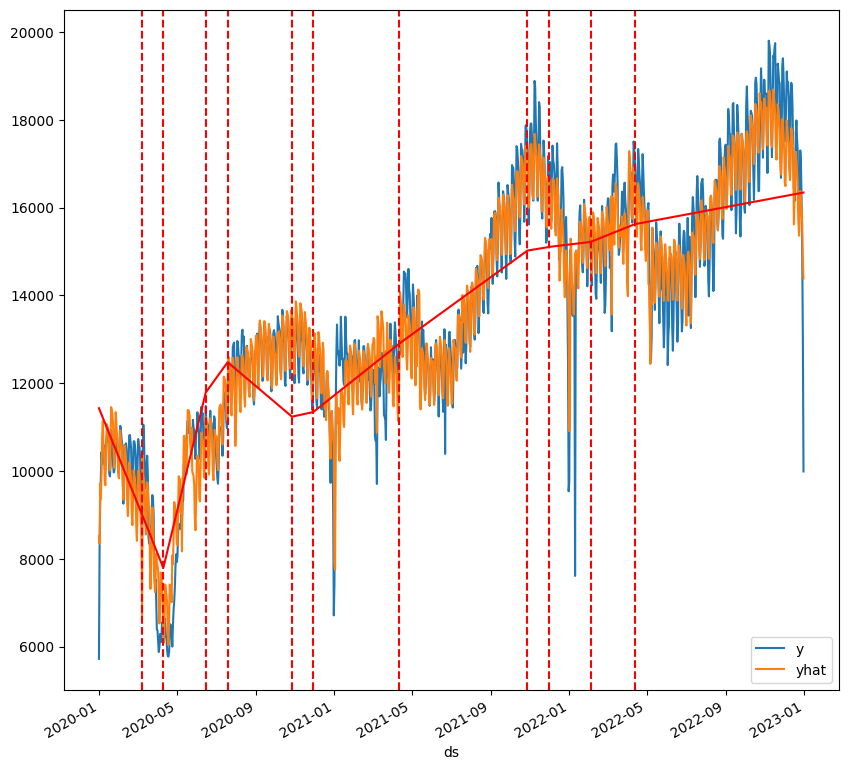

In [72]:
plot(model)

<Axes: >

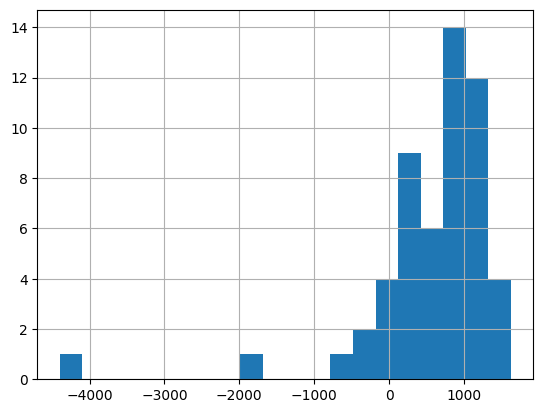

In [76]:
(test['y'] - predict_data['yhat']).hist(bins=20)

In [118]:
np.mean(test['y'] - predict_data['yhat'])

549.9145616276229

In [93]:
res = test.merge(predict_data[['ds', 'yhat']], on='ds', how='left')

In [94]:
res['residuals'] = res['yhat'] - res['y']

In [95]:
print('max: ',res['residuals'].idxmax())
print('min: ',res['residuals'].idxmin())

max:  53
min:  9


In [96]:
res = res.drop(53)
res = res.drop(9)

In [102]:
res = res[res['residuals'] > -1000]

In [107]:
res = res[res['residuals'] < 1000]

In [108]:
mean_absolute_percentage_error(res['y'], res['yhat'])

0.03081472054883217

<Axes: >

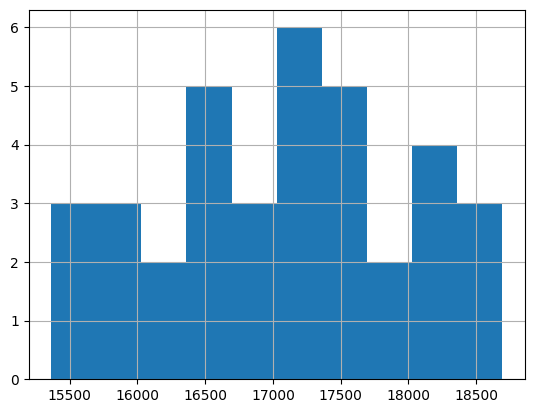

In [110]:
res['yhat'].hist()

In [111]:
model = Prophet(holidays=df_holidays, changepoint_range=0.8,
                **best_params).add_regressor('ramadan')

In [112]:
model.fit(data)

18:46:39 - cmdstanpy - INFO - Chain [1] start processing
18:46:40 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
ds = model.make_future_dataframe(365, include_history=True)

In [114]:
ds['ramadan'] = ds['ds'].apply(is_ramadan)

In [115]:
model.predict(ds)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Capital Day,Capital Day_lower,Capital Day_upper,Constitution Day of the Republic of Kazakhstan,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,11343.769265,7575.228637,9357.342870,11343.769265,11343.769265,0.0,0.0,0.0,0.0,...,372.911768,372.911768,372.911768,-1074.539576,-1074.539576,-1074.539576,0.0,0.0,0.0,8494.328817
1,2020-01-02,11310.879219,7315.465469,9070.216231,11310.879219,11310.879219,0.0,0.0,0.0,0.0,...,151.355098,151.355098,151.355098,-1113.518405,-1113.518405,-1113.518405,0.0,0.0,0.0,8200.903272
2,2020-01-03,11277.989173,8675.862575,10456.024809,11277.989173,11277.989173,0.0,0.0,0.0,0.0,...,-572.403497,-572.403497,-572.403497,-1137.342964,-1137.342964,-1137.342964,0.0,0.0,0.0,9568.242712
3,2020-01-04,11245.099127,8427.583712,10210.330283,11245.099127,11245.099127,0.0,0.0,0.0,0.0,...,-806.272574,-806.272574,-806.272574,-1145.834265,-1145.834265,-1145.834265,0.0,0.0,0.0,9292.992288
4,2020-01-05,11212.209081,8926.849085,10774.410861,11212.209081,11212.209081,0.0,0.0,0.0,0.0,...,-214.196421,-214.196421,-214.196421,-1139.081256,-1139.081256,-1139.081256,0.0,0.0,0.0,9858.931404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2023-12-27,18392.042341,9003.516218,26834.238265,9451.978400,27058.942174,0.0,0.0,0.0,0.0,...,372.911768,372.911768,372.911768,-676.094761,-676.094761,-676.094761,0.0,0.0,0.0,18088.859349
1455,2023-12-28,18396.723957,8923.813945,26269.758304,9414.906224,27091.253267,0.0,0.0,0.0,0.0,...,151.355098,151.355098,151.355098,-779.530856,-779.530856,-779.530856,0.0,0.0,0.0,17768.548199
1456,2023-12-29,18401.405573,7799.779144,25711.427162,9395.003240,27142.092519,0.0,0.0,0.0,0.0,...,-572.403497,-572.403497,-572.403497,-872.315099,-872.315099,-872.315099,0.0,0.0,0.0,16956.686976
1457,2023-12-30,18406.087188,7387.930471,25412.264790,9379.529070,27187.651350,0.0,0.0,0.0,0.0,...,-806.272574,-806.272574,-806.272574,-953.131421,-953.131421,-953.131421,0.0,0.0,0.0,16646.683194


In [116]:
res = model.predict(ds)

c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


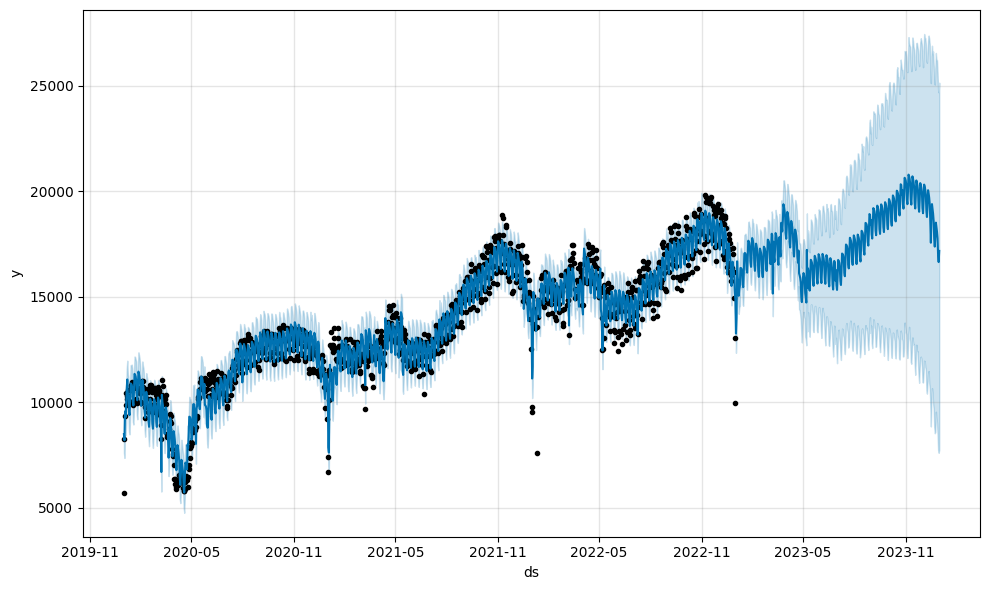

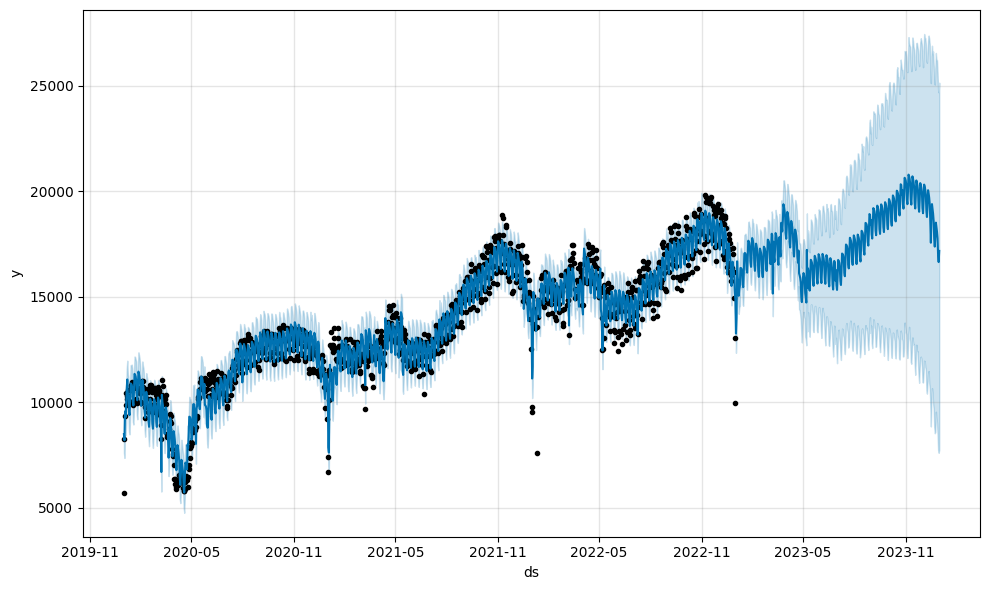

In [117]:
model.plot(res)